In [1]:
import pandas as pd

train_data = pd.read_csv('../input/Training.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('../input/Test.csv', encoding='ISO-8859-1')

First, let's remove unwanted features (like `id`, `track url`, `name`, etc). 

In [2]:
ignore = (['analysis_url', 
           'id', 
           'track_href', 
           'uri', 
           'type', 
           'album', 
           'name', 
           'duration_ms',
          ])

train_data.drop(ignore, axis=1, inplace=True)
clean_test_data = test_data.drop(ignore, axis=1)


Now, the important part: **which features am I gonna use?** What features define Steven Wilson's style the best?
  
After trying many combinations, analyzing some [graphs](https://www.kaggle.com/danielgrijalvas/comparing-steven-wilson-and-porcupine-tree) and checking with the Test dataset (a playlist with songs that may or may not sound like SW), I came to the conclusion that the best features for this problem are:
* Energy
* Instrumentalness
* Loudness
* Acousticness
* Valence  
  
However, using some statistical tools like a t-test, we can tell whether the features from class 1 are significantly different from class 2, and select those with higher significance. Using scikit-learn's `feature_selection` and `f_classif` (basically a t-test), the features with higher significance (or "score", according to [scikit-learn docs](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)) are:
* Danceability
* Instrumentalness
* Loudness
* Speechiness
* Valence  
  
See, I *almost* got it right. `SelectKBest` chose `Danceability` instead of `Energy`, and `Speechiness` instead of `Acousticness`. I understand that the data from `Energy` is very spread out and that's why it got a low score/significance; but `Speechiness`...? That seems weird.

In [3]:
from sklearn.feature_selection import SelectKBest

features = SelectKBest(k=4)
features.fit(train_data.loc[:, train_data.columns != 'class'], train_data['class'])

cols = list(train_data.columns[features.get_support(1)])


Now, let's train the machine learning algorithm, K-Nearest Neighbors. I'm leaving K as the default (5), but maybe later I'll try with higher values.

In [4]:
from sklearn.neighbors import KNeighborsClassifier as knn

# train KNN with training data 
kn = knn(n_neighbors=13, weights='distance', p=2)
kn.fit(train_data[cols], train_data['class'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='distance')

The algorithm is trained. Let's use what it learned to classify a playlist (`Test.csv`, a playlist with 100 songs that may or may not fit well between Steven Wilson songs). Also I'll add the predicted value and probabilites to the `Test` dataset.

In [5]:
# classify/predict class of test songs
predictions = kn.predict(test_data[cols])
test_data['predict'] = predictions

# probability that a song is 0/1
prob = kn.predict_proba(test_data[cols])
test_data['prob0'] = [p[0] for p in prob]
test_data['prob1'] = [p[1] for p in prob]

## Results
Let's check the results. If you want to check them yourself, give [Steven Wilson](https://open.spotify.com/artist/4X42BfuhWCAZ2swiVze9O0)/[Porcupine Tree](https://open.spotify.com/artist/5NXHXK6hOCotCF8lvGM1I0) a listen and then head over to the [Test playlist](https://open.spotify.com/user/jdgs.gt/playlist/6wCTUaDlzdzrqMUzkCd9Zx) and listen to the songs where `prob1` is 1 to check similarities. Or listen to the songs where `prob0` is 1, and you'll see the huge differences of musical style.

 **UPDATE**: I added the songs with > 80% probability of being **1**  (similar to Steven Wilson) to [this playlist](https://open.spotify.com/user/jdgs.gt/playlist/0D7EWUrrBuza4H8SuzDqyI). It's just 35 songs long, but the results are really good. 

In [6]:
# full results
test_data[['name', 'class', 'predict', 'prob0', 'prob1']]

,name,class,predict,prob0,prob1
0,Animals,0.0,0,0.613088,0.386912
1,The Closest I've Come,0.0,1,0.351881,0.648119
2,Coma Pony,0.0,0,0.936205,0.063795
3,Doce,0.0,0,0.748637,0.251363
4,The End Is Begun,0.0,0,1.000000,0.000000
5,(Go) Get It,0.0,0,0.698240,0.301760
6,Heartbreaker,0.0,0,0.624496,0.375504
7,The Invisible Man,1.0,1,0.253858,0.746142
8,Kodokunohatsumei,0.0,0,0.653547,0.346453
9,The Lesson,0.0,0,0.629534,0.370466


### False positives
Ok, so how many songs were classified as Steven Wilson?

In [7]:
len(test_data[test_data['predict'] == 1])

42

And how many are **actually** like Steven Wilson?

In [8]:
len(test_data[test_data['class']== 1])

28

As you can see, there are some songs (14) that were classified to be like Steven Wilson, but aren't. The algorithm did a pretty good job at separating songs "by genre" (songs that are somewhat likely to sound like SW vs. songs that are **totally** different from SW), but it's hard to separate the songs *inside* the genre that Steven Wilson is in.

A way to visualize the false positives vs. the true positives is using a [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). This is useful for testing the performance of a binary classifier like this.

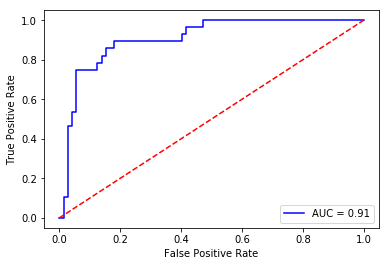

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

actual = test_data['class']
predictions = test_data['prob1']

false_positives, true_positives, threshold = roc_curve(actual, predictions)
area_under_curve = auc(false_positives, true_positives)

# plot
plt.plot(false_positives, true_positives, 'b', label='AUC = %0.2f'% area_under_curve)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

It appears that the classifier has a poor performance, because it *recommends* you songs that actually aren't like the positive class (in this case, songs similar to Steven Wilson). As of right now, it has an accuracy of ~~67%~~ 91% (it will go up as I add more training songs).

For context, here's what a perfect ROC curve looks like:
![](https://i.imgur.com/xMZ3C1R.png)

See? No false positives! and the AUC (Area Under Curve) equals 1. That's what I'm aiming for, the first step is: add more data! 